In [1]:
'''The Frame is borrowed from'''

"""In progress.

Parag K. Mital, Jan 2016.
"""

'In progress.\n\nParag K. Mital, Jan 2016.\n'

In [2]:
# %%
import tensorflow as tf
from libs.connections import conv2d, linear
from collections import namedtuple
from math import sqrt


import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
import time
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# %%
def residual_network(x, n_outputs,
                     activation=tf.nn.relu):
    """Builds a residual network.

    Parameters
    ----------
    x : Placeholder
        Input to the network
    n_outputs : TYPE
        Number of outputs of final softmax
    activation : Attribute, optional
        Nonlinearity to apply after each convolution

    Returns
    -------
    net : Tensor
        Description

    Raises
    ------
    ValueError
        If a 2D Tensor is input, the Tensor must be square or else
        the network can't be converted to a 4D Tensor.
    """
    # %%
    LayerBlock = namedtuple(
        'LayerBlock', ['num_repeats', 'num_filters', 'bottleneck_size'])
    blocks = [LayerBlock(3, 128, 32),
              LayerBlock(3, 256, 64),
              LayerBlock(3, 512, 128),
              LayerBlock(3, 1024, 256)]

    # %%
    input_shape = x.get_shape().as_list()
    if len(input_shape) == 2:
        ndim = int(sqrt(input_shape[1]))
        if ndim * ndim != input_shape[1]:
            raise ValueError('input_shape should be square')
        x = tf.reshape(x, [-1, ndim, ndim, 1])

    # %%
    # First convolution expands to 64 channels and downsamples
    net = conv2d(x, 64, k_h=7, k_w=7,
                 name='conv1',
                 activation=activation)

    # %%
    # Max pool and downsampling
    net = tf.nn.max_pool(
        net, [1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

    # %%
    # Setup first chain of resnets
    net = conv2d(net, blocks[0].num_filters, k_h=1, k_w=1,
                 stride_h=1, stride_w=1, padding='VALID', name='conv2')

    # %%
    # Loop through all res blocks
    for block_i, block in enumerate(blocks):
        for repeat_i in range(block.num_repeats):

            name = 'block_%d/repeat_%d' % (block_i, repeat_i)
            conv = conv2d(net, block.bottleneck_size, k_h=1, k_w=1,
                          padding='VALID', stride_h=1, stride_w=1,
                          activation=activation,
                          name=name + '/conv_in')

            conv = conv2d(conv, block.bottleneck_size, k_h=3, k_w=3,
                          padding='SAME', stride_h=1, stride_w=1,
                          activation=activation,
                          name=name + '/conv_bottleneck')

            conv = conv2d(conv, block.num_filters, k_h=1, k_w=1,
                          padding='VALID', stride_h=1, stride_w=1,
                          activation=activation,
                          name=name + '/conv_out')

            net = conv + net
        try:
            # upscale to the next block size
            next_block = blocks[block_i + 1]
            net = conv2d(net, next_block.num_filters, k_h=1, k_w=1,
                         padding='SAME', stride_h=1, stride_w=1, bias=False,
                         name='block_%d/conv_upscale' % block_i)
        except IndexError:
            pass

    # %%
    net = tf.nn.avg_pool(net,
                         ksize=[1, net.get_shape().as_list()[1],
                                net.get_shape().as_list()[2], 1],
                         strides=[1, 1, 1, 1], padding='VALID')
    net = tf.reshape(
        net,
        [-1, net.get_shape().as_list()[1] *
         net.get_shape().as_list()[2] *
         net.get_shape().as_list()[3]])

    net = linear(net, n_outputs, activation=tf.nn.softmax)
    
    

    # %%
    return net

In [4]:
def test_mnist():
    """Test the resnet on MNIST."""
    import tensorflow.examples.tutorials.mnist.input_data as input_data

    mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])
    y_pred = residual_network(x, 10)

    # %% Define loss/eval/training functions
    cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))
    optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

    # %% Monitor accuracy
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

    # %% We now create a new session to actually perform the initialization the
    # variables:
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())

    # %% We'll train in minibatches and report accuracy:
    batch_size = 50
    n_epochs = 1
    
    epo_t = [time.clock()]
    loss = []
    t_acc = []
    train_accuracy = 0

    
    for epoch_i in range(n_epochs):
        
        bt_t = [time.clock()]
        
        # Training
    
        cnt = 0
        for batch_i in range(mnist.train.num_examples // batch_size):
            
            
            
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, l, predictions = sess.run([optimizer, cross_entropy, accuracy], feed_dict={
                x: batch_xs, y: batch_ys})
            train_accuracy += predictions
            t_acc.append(train_accuracy)
            
            loss.append(l)
            bt_t = [time.clock()]   
            
            
            
        train_accuracy /= (mnist.train.num_examples // batch_size)
        
        epo_t.append(time.clock())
        
        cnt += 1
        

        # Validation
        valid_accuracy = 0
        for batch_i in range(mnist.validation.num_examples // batch_size):
            batch_xs, batch_ys = mnist.validation.next_batch(batch_size)
            valid_accuracy += sess.run(accuracy,
                                       feed_dict={
                                           x: batch_xs,
                                           y: batch_ys
                                       })
        valid_accuracy /= (mnist.validation.num_examples // batch_size)
        print('epoch:', epoch_i, ', train:',
              train_accuracy, ', valid:', valid_accuracy)
        
    pickle_file = 'notMNIST.pickle'
    try:
        f = open(pickle_file, 'wb')
        save = {
            'epo_t': epo_t,
            'bt_t': bt_t,
            'loss': loss,
            'train_accuracy': t_acc,
            }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise




In [5]:
if __name__ == '__main__':
    test_mnist()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('epoch:', 0, ', train:', 0.85892727063122121, ', valid:', 0.94519999623298645)


In [6]:
pickle_file = 'notMNIST.pickle'
Full_data = pickle.load( open( pickle_file, "rb" ) )

epo_t = Full_data['epo_t']
bt_t = Full_data['bt_t']
loss = Full_data['loss']
train_accuracy = Full_data['train_accuracy']

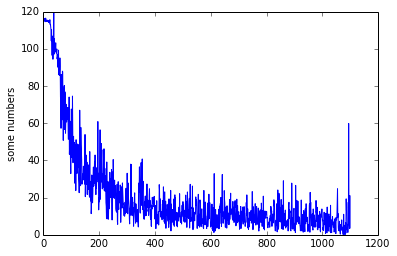

In [7]:
plt.plot(loss)
plt.ylabel('some numbers')
plt.show()

In [ ]:
type(loss)

In [ ]:
loss.shape

In [ ]:
print(loss)